# EDA
**Изучаем качество данных и базовые статистики, копия основного ноута для проверки аугментированного датасета**

## Загрузка данных и первичная инфо

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import normaltest

import gensim
import pyLDAvis
import pyLDAvis.gensim_models

import random
import ast

random.seed(42)
np.random.seed(42)

/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Загружаем датасет
df = pd.read_csv("customer_support_dataset_generated.csv")
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [3]:
df.response[0] # Пример ответа

"I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40366 entries, 0 to 40365
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        40366 non-null  object
 1   instruction  40366 non-null  object
 2   category     40366 non-null  object
 3   intent       40366 non-null  object
 4   response     40366 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [5]:
df.describe(include='all')

,flags,instruction,category,intent,response
count,40366,40366,40366,40366,40366
unique,1078,36133,85,169,40132
top,BL,What are the accepted payment methods?,ACCOUNT,track_refund,Our refund policy allows for returns within 30...
freq,7170,23,8828,1746,15


In [6]:
df['instruction'] = df['instruction'].astype(str).str.strip()

print("Пустые строки:", (df['instruction'].isnull()).sum())
print("Дубликаты:", df.duplicated('instruction').sum())

df[df.duplicated('instruction')].sort_values('instruction')

Пустые строки: 0
Дубликаты: 4233


,flags,instruction,category,intent,response
36662,B,Account creation failed.,ACCOUNT,registration_problems,I'm sorry to hear that account creation failed...
34159,B,Account creation failed.,ACCOUNT,registration_problems,I'm sorry to hear your account creation failed...
28641,BQ,Any news on my refund?,REFUND,track_refund,I can check for news on your refund. Please pr...
36598,ILQ,Any news on my refund?,REFUND,track_refund,I can check for news on your refund! Could you...
34120,BQ,Any news on my refund?,REFUND,track_refund,Let me check for any news regarding your refun...
...,...,...,...,...,...
834,BIL,where to cancel purchase {{Order Number}}?,ORDER,cancel_order,"To cancel purchase {{Order Number}}, please fo..."
25802,BIL,where to see order {{Order Number}} status?,ORDER,track_order,I appreciate your inquiry! To view the status ...
24694,BIQ,where to switch to the {{Account Type}} account,ACCOUNT,switch_account,Great question! I'd be delighted to assist you...
39267,BQ,where's my invoice?,INVOICE,get_invoice,Your invoice is available in your account unde...


In [7]:
df['response'] = df['response'].astype(str).str.strip()

print("Пустые строки:", (df['response'].isnull()).sum())
print("Дубликаты:", df.duplicated('response').sum())

df[df.duplicated('response')].sort_values('response')

Пустые строки: 0
Дубликаты: 234


,flags,instruction,category,intent,response
39766,BL,Could you guide me to create an account and th...,ACCOUNT,create_account,"Absolutely! To create an account, please visit..."
35124,BLPQ,"I'd like to switch my account, please assist.",ACCOUNT,switch_account,Certainly! I can assist you with switching you...
39145,BIL,"I can't remember my password, please help me r...",ACCOUNT,recover_password,Certainly! I can help you recover your passwor...
33644,PBL,I want to track my refund.,REFUND,track_refund,Certainly! I can help you track your refund. P...
27759,M P,Can you please track my refund for me?,REFUND,track_refund,Certainly! I'd be happy to track your refund f...
...,...,...,...,...,...
34686,L,I want to see my invoice.,INVOICE,check_invoice,You can see your invoice by logging into your ...
27864,BIE,What payment options can I use?,PAYMENT,check_payment_methods,"You can use Visa, MasterCard, American Express..."
37655,BL,I need to view my invoice.,INVOICE,get_invoice,You can view your invoice by logging into your...
32992,PQ,What are my payment choices?,PAYMENT,check_payment_methods,You have several payment choices! We accept Vi...


In [8]:
df['category'].unique()

# дубли из-за перестановок и дубли категорий

array(['ORDER', 'SHIPPING_ADDRESS', 'CANCEL', 'INVOICE', 'PAYMENT',
       'REFUND', 'FEEDBACK', 'CONTACT', 'ACCOUNT', 'DELIVERY',
       'SUBSCRIPTION', "['ACCOUNT', 'ORDER']", "['REFUND', 'REFUND']",
       "['SUBSCRIPTION', 'CANCELLATION_FEE']", 'CANCELLATION_FEE',
       "['DELIVERY', 'ACCOUNT']", "['ACCOUNT', 'DELIVERY']",
       "['INVOICE', 'ORDER']", "['INVOICE', 'PAYMENT']",
       "['FEEDBACK', 'INVOICE']", "['INVOICE', 'FEEDBACK']",
       "['CONTACT', 'ACCOUNT']", "['CONTACT', 'INVOICE']",
       "['ORDER', 'CANCELLATION_FEE']", "['SHIPPING_ADDRESS', 'CONTACT']",
       "['REFUND', 'DELIVERY']", "['SHIPPING_ADDRESS', 'ORDER']",
       "['ACCOUNT', 'CANCELLATION_FEE']",
       "['SHIPPING_ADDRESS', 'ACCOUNT']", "['FEEDBACK', 'REFUND']",
       "['SHIPPING_ADDRESS', 'PAYMENT']", "['ORDER', 'DELIVERY']",
       "['SHIPPING_ADDRESS', 'REFUND']", "['FEEDBACK', 'CONTACT']",
       "['ORDER', 'REFUND']", "['ORDER', 'CONTACT']",
       "['ACCOUNT', 'INVOICE']", "['REFUND', 'SHIPPIN

In [9]:
def process_category_unique(value):
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        try:
            categories = ast.literal_eval(value)
            unique_categories = list(set(categories))
            # Если осталась одна категория - возвращаем как строку
            if len(unique_categories) == 1:
                return unique_categories[0]
            else:
                return ', '.join(sorted(unique_categories))
        except:
            return value
    else:
        return value

# Применяем нужный вариант
df['category'] = df['category'].apply(process_category_unique).astype(str)

df['category'].unique()

array(['ORDER', 'SHIPPING_ADDRESS', 'CANCEL', 'INVOICE', 'PAYMENT',
       'REFUND', 'FEEDBACK', 'CONTACT', 'ACCOUNT', 'DELIVERY',
       'SUBSCRIPTION', 'ACCOUNT, ORDER', 'CANCELLATION_FEE, SUBSCRIPTION',
       'CANCELLATION_FEE', 'ACCOUNT, DELIVERY', 'INVOICE, ORDER',
       'INVOICE, PAYMENT', 'FEEDBACK, INVOICE', 'ACCOUNT, CONTACT',
       'CONTACT, INVOICE', 'CANCELLATION_FEE, ORDER',
       'CONTACT, SHIPPING_ADDRESS', 'DELIVERY, REFUND',
       'ORDER, SHIPPING_ADDRESS', 'ACCOUNT, CANCELLATION_FEE',
       'ACCOUNT, SHIPPING_ADDRESS', 'FEEDBACK, REFUND',
       'PAYMENT, SHIPPING_ADDRESS', 'DELIVERY, ORDER',
       'REFUND, SHIPPING_ADDRESS', 'CONTACT, FEEDBACK', 'ORDER, REFUND',
       'CONTACT, ORDER', 'ACCOUNT, INVOICE', 'REFUND, SUBSCRIPTION',
       'PAYMENT, REFUND', 'ACCOUNT, REFUND', 'FEEDBACK, SHIPPING_ADDRESS',
       'CONTACT, DELIVERY', 'CANCELLATION_FEE, CONTACT', 'ORDER, PAYMENT',
       'INVOICE, SHIPPING_ADDRESS', 'INVOICE, SUBSCRIPTION',
       'FEEDBACK, ORDER

## Анализируем датасет детальнее 
Смотрим на слова, символы, изучаем категории

In [10]:
df['n_words'] = df['instruction'].str.split().apply(len)
df['n_chars'] = df['instruction'].str.len()
df[['n_words', 'n_chars']].describe()

,n_words,n_chars
count,40366.000000,40366.000000
mean,8.490660,45.170267
std,2.628593,11.977874
min,1.000000,6.000000
25%,7.000000,37.000000
50%,8.000000,46.000000
75%,10.000000,54.000000
max,27.000000,144.000000


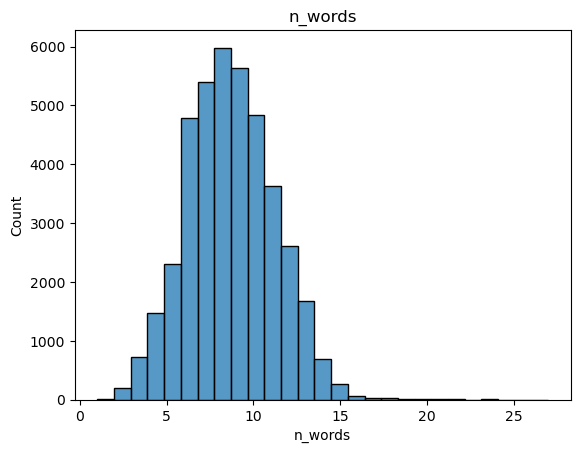

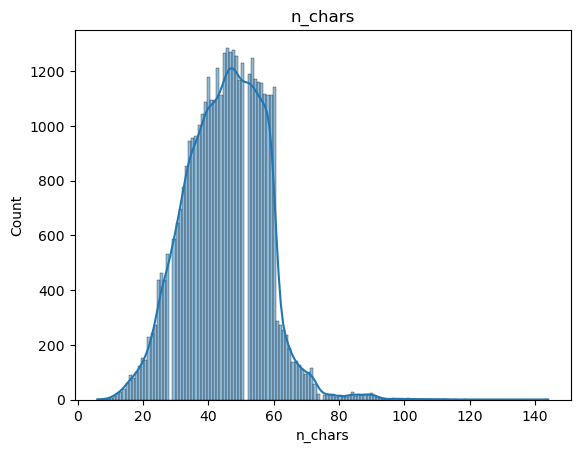

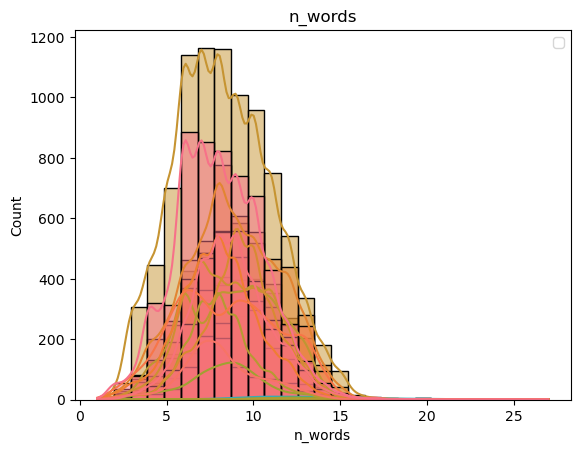

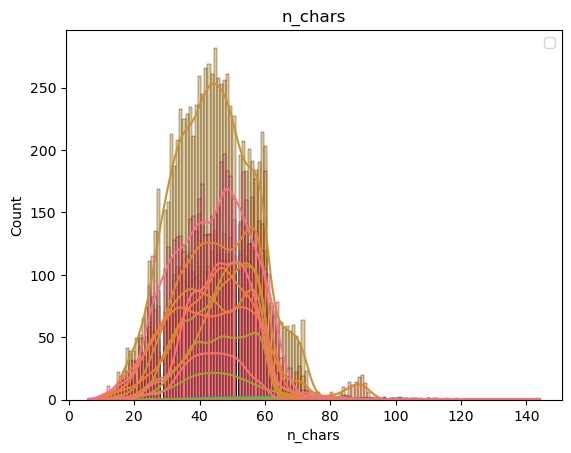

In [11]:
sns.histplot(data=df, x="n_words", bins=27).set_title("n_words")
plt.show()

sns.histplot(data=df, x="n_chars", kde=True, bins=144).set_title("n_chars")
plt.show()


##

sns.histplot(data=df, x="n_words", kde=True, hue='category', bins=27).set_title("n_words")
plt.legend('')
plt.show()

sns.histplot(data=df, x="n_chars", kde=True, hue='category', bins=144).set_title("n_chars")
plt.legend('')
plt.show()

In [12]:
# Проверка на нормальность стат. критерием

def dagostino_test(data, alpha=0.05):
    stat, p_value = normaltest(data)
    print(f"Тест Д'Агостино на нормальность распределения n_words:")
    print(f"Статистика: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value > alpha:
        print("Не отвергаем H0 - данные нормально распределены")
    else:
        print("Отвергаем H0 - данные не нормально распределены")
    
    return stat, p_value

# Использование
stat, p_value = dagostino_test(df['n_words'])

Тест Д'Агостино на нормальность распределения n_words:
Статистика: 346.3755
p-value: 0.0000
Отвергаем H0 - данные не нормально распределены


In [13]:
df[df['n_words'] <= 2]

,flags,instruction,category,intent,response,n_words,n_chars
83,BK,cancelling order,ORDER,cancel_order,I've come to understand that you would like to...,2,16
311,BK,canceling order,ORDER,cancel_order,"I pick up what you're putting down, your need ...",2,15
370,BKLZ,cancel purchase732201349959,ORDER,cancel_order,I'm on your side your need for assistance with...,2,27
711,BK,order cancelation,ORDER,cancel_order,I've noticed that you would like to cancel you...,2,17
729,BKLZ,cancel purchase370795561790,ORDER,cancel_order,I'm on your side your need to cancel your purc...,2,27
...,...,...,...,...,...,...,...
39873,B,Send invoice.,INVOICE,get_invoice,Sure. Please provide your order number or acco...,2,13
39878,B,Invoice needed.,INVOICE,get_invoice,Please provide your account number or order ID...,2,15
39883,B,Invoice access.,INVOICE,get_invoice,Please provide your account number or order ID...,2,15
40008,BKQ,Show invoice.,INVOICE,check_invoice,"To show you the invoice, I need a bit more inf...",2,13


In [14]:
df[df['n_words'] <= 1]

,flags,instruction,category,intent,response,n_words,n_chars
7449,B,complaint,FEEDBACK,complaint,I gather that you have a complaint and I want ...,1,9
9025,BLZ,contactingassistant,CONTACT,contact_human_agent,It's great to hear from you! I can see that yo...,1,19
10231,BK,register,ACCOUNT,create_account,Thank you for expressing your interest in regi...,1,8
19665,BKZ,makepurchase,ORDER,place_order,I appreciate your intention to make a purchase...,1,12
22443,BK,review,FEEDBACK,review,Thank you for choosing to leave a review! Your...,1,6
36999,B,Invoice.,INVOICE,check_invoice,"To assist you with your invoice, please provid...",1,8


Нет аномалий в коротких обращениях - такие могут встречаться и в реальной жизни

### Анализ слов и частот

In [15]:
# from collections import Counter
# import re
# from nltk.corpus import stopwords

def get_top_words(texts, n=20):
    words = " ".join(texts).lower()
    words = re.findall(r'\b\w+\b', words)
    return Counter(words).most_common(n)

get_top_words(df['instruction'])

# много не очень полезных слов - нужно почистить

[('i', 27765),
 ('to', 22921),
 ('my', 11909),
 ('the', 9865),
 ('a', 9570),
 ('can', 7955),
 ('account', 7379),
 ('order', 7152),
 ('help', 7020),
 ('do', 6638),
 ('need', 6438),
 ('how', 5945),
 ('me', 5359),
 ('what', 5027),
 ('want', 4722),
 ('of', 4636),
 ('for', 4261),
 ('with', 3299),
 ('you', 3193),
 ('have', 3128)]

Много не очень информативных слов - почистим их

In [16]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [17]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))  # или 'russian', 'spanish' и т.д.


def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_instruction'] = df['instruction'].apply(remove_stopwords)

get_top_words(df['clean_instruction'], n=20)

[('account', 7379),
 ('order', 7151),
 ('help', 7020),
 ('need', 6438),
 ('want', 4722),
 ('assistance', 3118),
 ('number', 3110),
 ('know', 3080),
 ('address', 2976),
 ('refund', 2819),
 ('see', 2675),
 ('check', 2454),
 ('payment', 2408),
 ('delivery', 2345),
 ('shipping', 2057),
 ('get', 1904),
 ('purchase', 1870),
 ('invoice', 1610),
 ('could', 1537),
 ('customer', 1537)]

In [18]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))  # или 'russian', 'spanish' и т.д.


def remove_stopwords(text):
    
    # Удаляем различные шаблоны с фигурными скобками
    patterns_to_remove = [r'{{.*?}}']
    
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
        
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_instruction'] = df['instruction'].apply(remove_stopwords)

get_top_words(df['clean_instruction'], n=20)

[('help', 7020),
 ('need', 6438),
 ('account', 5546),
 ('want', 4722),
 ('order', 4217),
 ('assistance', 3118),
 ('know', 3080),
 ('address', 2976),
 ('see', 2675),
 ('check', 2454),
 ('payment', 2408),
 ('refund', 2195),
 ('shipping', 2057),
 ('delivery', 1934),
 ('get', 1904),
 ('purchase', 1870),
 ('invoice', 1602),
 ('could', 1537),
 ('customer', 1537),
 ('cancel', 1379)]

/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_9

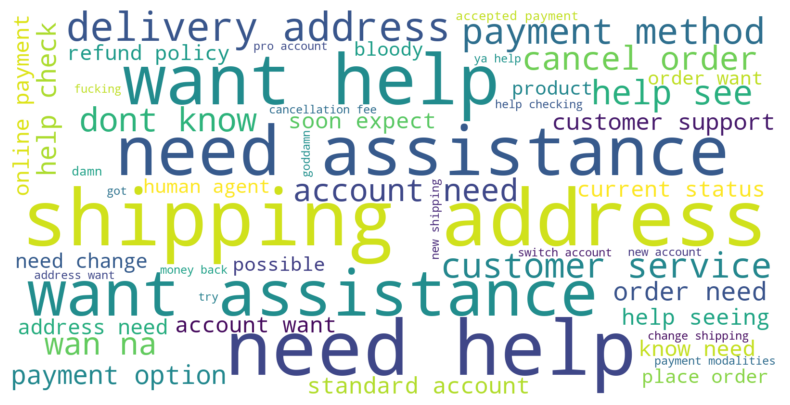

In [19]:
# Создание облака слов
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=50
).generate(' '.join(df['clean_instruction'].astype(str).tolist()))

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## n-граммы
Какие устойчивые фразы часто встречаются?

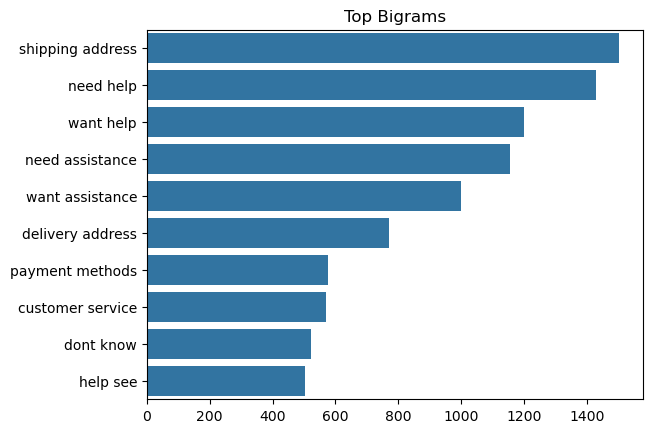

Text(0.5, 1.0, 'Top Trigrams')

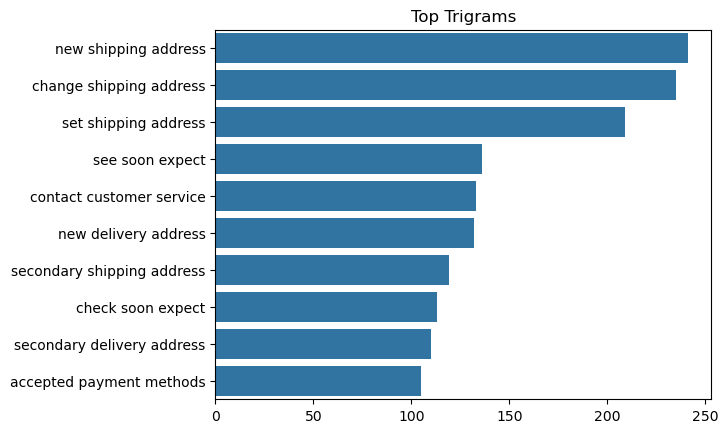

In [20]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

# get_top_ngram(df['clean_instruction'], 2)

top_n_bigrams=get_top_ngram(df['clean_instruction'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x).set_title('Top Bigrams')
plt.show()

top_n_trigrams=get_top_ngram(df['clean_instruction'],3)[:10] 
x,y=map(list,zip(*top_n_trigrams)) 
sns.barplot(x=y,y=x).set_title('Top Trigrams')

In [21]:
def get_top_ngram_with_intents(corpus, intents, n=None, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Анализ интентов для каждой n-граммы
    ngrams_with_intents = []
    for word, freq in words_freq[:top_k]:
        # Находим документы, содержащие эту n-грамму
        word_idx = vec.vocabulary_[word]
        documents_with_ngram = [i for i in range(len(corpus)) 
                               if bag_of_words[i, word_idx] > 0]
        
        # Собираем интенты для этих документов
        associated_intents = intents.iloc[documents_with_ngram]
        top_intents = associated_intents.value_counts().head(3)
        
        ngrams_with_intents.append({
            'ngram': word,
            'frequency': freq,
            'top_intents': dict(top_intents)
        })
    
    return ngrams_with_intents

In [22]:
# Анализ для биграмм
top_bigrams_with_intents = get_top_ngram_with_intents(
    df['clean_instruction'], 
    df['intent'], 
    2, 
    10
)

# Вывод результатов
print("Top Bigrams with Intents:")
for item in top_bigrams_with_intents:
    print(f"\n{item['ngram']}: {item['frequency']} occurrences")
    for intent, count in item['top_intents'].items():
        print(f"  - {intent}: {count} times")

Top Bigrams with Intents:

shipping address: 1503 occurrences
  - set_up_shipping_address: 848 times
  - change_shipping_address: 558 times
  - change_order: 17 times

need help: 1429 occurrences
  - cancel_order: 97 times
  - recover_password: 76 times
  - payment_issue: 73 times

want help: 1201 occurrences
  - payment_issue: 71 times
  - check_payment_methods: 67 times
  - complaint: 65 times

need assistance: 1154 occurrences
  - cancel_order: 69 times
  - payment_issue: 64 times
  - recover_password: 62 times

want assistance: 998 occurrences
  - payment_issue: 77 times
  - registration_problems: 64 times
  - check_payment_methods: 58 times

delivery address: 772 occurrences
  - set_up_shipping_address: 477 times
  - change_shipping_address: 288 times
  - ['check_cancellation_fee', 'change_shipping_address']: 3 times

payment methods: 577 occurrences
  - check_payment_methods: 541 times
  - ['get_invoice', 'check_payment_methods']: 13 times
  - ['check_invoice', 'check_payment_met

In [23]:
# Анализ для триграмм
top_trigrams_with_intents = get_top_ngram_with_intents(
    df['clean_instruction'], 
    df['intent'], 
    3, 
    10
)

# Вывод результатов
print("Top Trigrams with Intents:")
for item in top_trigrams_with_intents:
    print(f"\n{item['ngram']}: {item['frequency']} occurrences")
    for intent, count in item['top_intents'].items():
        print(f"  - {intent}: {count} times")

Top Trigrams with Intents:

new shipping address: 241 occurrences
  - set_up_shipping_address: 227 times
  - ['set_up_shipping_address', 'delivery_options']: 8 times
  - ['complaint', 'set_up_shipping_address']: 2 times

change shipping address: 235 occurrences
  - change_shipping_address: 188 times
  - change_order: 11 times
  - ['change_order', 'set_up_shipping_address']: 4 times

set shipping address: 209 occurrences
  - set_up_shipping_address: 201 times
  - ['complaint', 'set_up_shipping_address']: 7 times
  - change_shipping_address: 1 times

see soon expect: 136 occurrences
  - delivery_period: 136 times

contact customer service: 133 occurrences
  - contact_customer_service: 121 times
  - contact_human_agent: 2 times
  - ['contact_customer_service', 'contact_human_agent']: 2 times

new delivery address: 132 occurrences
  - set_up_shipping_address: 132 times

secondary shipping address: 119 occurrences
  - set_up_shipping_address: 119 times

check soon expect: 113 occurrences
  

## Визуализация эмбеддингов

Как тексты распределяются в векторном пространстве?

- TF-IDF преобразует текст в числовые векторы, где важные слова имеют больший вес
- PCA уменьшает размерность с 500 до 2 компонент для визуализации

In [24]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['clean_instruction'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

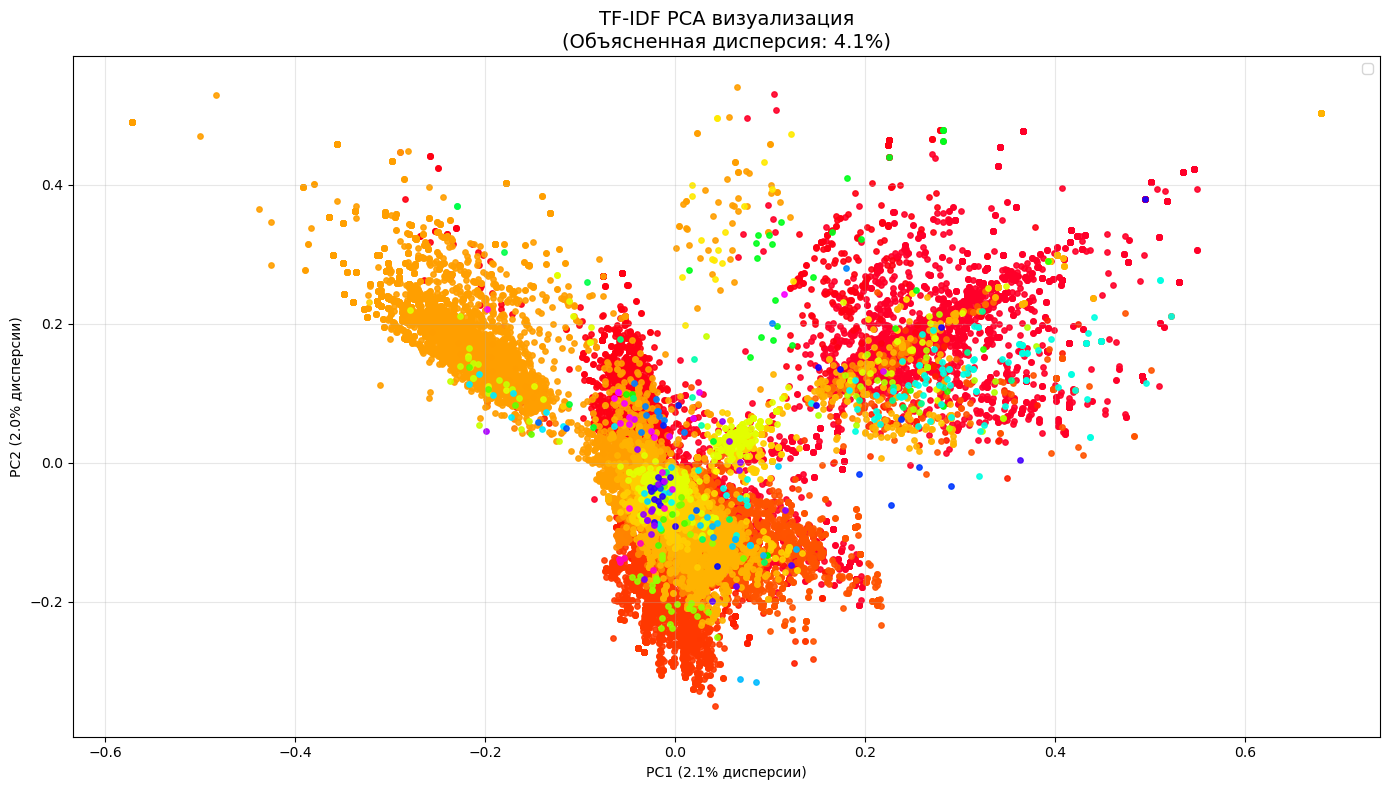

In [26]:
# Создаем красивый график с информацией о категориях
plt.figure(figsize=(14, 8))

categories = df['category'].unique()
colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    mask = df['category'] == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                alpha=0.9, s=15, 
                color=colors[i], 
                cmap='jet',
                label=category)

plt.title(f"TF-IDF PCA визуализация\n(Объясненная дисперсия: {pca.explained_variance_ratio_.sum()*100:.1f}%)", size=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% дисперсии)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% дисперсии)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.legend('')
plt.tight_layout()
plt.show()

In [27]:
print("Объясненная дисперсия каждой компоненты:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")

print(f"\nСуммарная объясненная дисперсия: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

Объясненная дисперсия каждой компоненты:
PC1: 0.021 (2.1%)
PC2: 0.020 (2.0%)

Суммарная объясненная дисперсия: 0.041 (4.1%)


In [28]:
# Смотрим самые важные слова для каждой компоненты
feature_names = tfidf.get_feature_names_out()

print("Топ-10 слов для PC1 (первая компонента):")
for i in pca.components_[0].argsort()[-10:][::-1]:
    print(f"  {feature_names[i]}: {pca.components_[0][i]:.3f}")

print("\nТоп-10 слов для PC2 (вторая компонента):")
for i in pca.components_[1].argsort()[-10:][::-1]:
    print(f"  {feature_names[i]}: {pca.components_[1][i]:.3f}")

Топ-10 слов для PC1 (первая компонента):
  order: 0.697
  cancel: 0.183
  status: 0.174
  refund: 0.121
  check: 0.096
  see: 0.095
  place: 0.085
  purchase: 0.082
  track: 0.073
  current: 0.060

Топ-10 слов для PC2 (вторая компонента):
  order: 0.528
  account: 0.515
  change: 0.236
  cancel: 0.166
  address: 0.153
  shipping: 0.111
  new: 0.105
  create: 0.085
  place: 0.072
  switch: 0.070


In [29]:
# from sklearn.metrics import silhouette_score

# Оцениваем качество кластеризации
silhouette_avg = silhouette_score(X_pca, df['category'].astype('category').cat.codes)
print(f"Silhouette Score: {silhouette_avg:.3f}")

if silhouette_avg < 0.5:
    print("Категории плохо разделяются в пространстве TF-IDF")
    print("Возможные причины:")
    print("- Тексты разных категорий используют похожие слова")
    print("- TF-IDF недостаточно для разделения")
    print("- Нужна дополнительная предобработка текста")

Silhouette Score: -0.647
Категории плохо разделяются в пространстве TF-IDF
Возможные причины:
- Тексты разных категорий используют похожие слова
- TF-IDF недостаточно для разделения
- Нужна дополнительная предобработка текста


## Latent Dirichlet Allocation (LDA) 

Простая в использовании и эффективная модель для тематического моделирования. Каждый документ представлен распределением тем, а каждая тема — распределением слов.

In [30]:
# import nltk
# from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

def preprocess_news(df):
    corpus=[]
    #stem=PorterStemmer() # ищем основы, убирая суффиксы
    lem=WordNetLemmatizer() # ищет основы, используя словарь и части речи
    for news in df['clean_instruction']:
        words=[w for w in word_tokenize(news) if (w not in stop)]

        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

corpus=preprocess_news(df)

[nltk_data] Downloading package punkt to /Users/vadim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vadim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# bag of words
# import gensim
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 11, # столько категорий
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
sorted(lda_model.show_topics(), key=lambda item: item[0])

[(0,
  '0.101*"order" + 0.090*"purchase" + 0.079*"item" + 0.075*"like" + 0.068*"cancel" + 0.047*"product" + 0.042*"want" + 0.041*"help" + 0.033*"would" + 0.023*"make"'),
 (1,
  '0.401*"need" + 0.143*"order" + 0.090*"change" + 0.089*"know" + 0.060*"update" + 0.041*"assistance" + 0.021*"dont" + 0.007*"location" + 0.007*"placing" + 0.006*"cancelling"'),
 (2,
  '0.153*"address" + 0.125*"shipping" + 0.071*"new" + 0.054*"order" + 0.051*"issue" + 0.043*"set" + 0.042*"want" + 0.034*"help" + 0.032*"place" + 0.023*"possible"'),
 (3,
  '0.109*"newsletter" + 0.046*"want" + 0.039*"subscribe" + 0.039*"subscription" + 0.036*"help" + 0.031*"cancel" + 0.031*"service" + 0.030*"sign" + 0.030*"feedback" + 0.029*"product"'),
 (5,
  '0.122*"want" + 0.094*"assistance" + 0.081*"customer" + 0.076*"service" + 0.043*"support" + 0.041*"contact" + 0.037*"agent" + 0.036*"talk" + 0.036*"speak" + 0.035*"show"'),
 (6,
  '0.161*"invoice" + 0.142*"get" + 0.119*"please" + 0.077*"refund" + 0.052*"could" + 0.036*"policy" +

In [32]:
# # import pyldavis
# import pyLDAvis
# import pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
# vis
